In [93]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import imageio
from PIL import Image
import matplotlib.image as mpimg
from typing import Tuple
import os
import random
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from joblib import dump, load
from collections import namedtuple
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import seaborn as sns

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import Callback

from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer

In [94]:
# GPU 할당량 조정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*3.5)]) # 1660super 총 vram 6gb 중 5.5gb 할당
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [95]:
class InnerConv1DBlock(tf.keras.layers.Layer):
    def __init__(self, filters: int, h: int, kernel_size: int, neg_slope: float = .01, dropout: float = .5,
                 name: str = ''):
        super(InnerConv1DBlock, self).__init__(name=name)
        self.conv1d = tf.keras.layers.Conv1D(h * filters, kernel_size, padding='same')
        self.leakyrelu = tf.keras.layers.LeakyReLU(neg_slope)

        self.dropout = tf.keras.layers.Dropout(dropout)

        self.conv1d2 = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')
        self.tanh = tf.keras.activations.tanh

    def call(self, input_tensor):
        x = self.conv1d(input_tensor)
        x = self.leakyrelu(x)

        x = self.dropout(x)

        x = self.conv1d2(x)
        x = self.tanh(x)
        return x


class Exp(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Exp, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.math.exp(inputs)


class Split(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Split, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs[:, ::2], inputs[:, 1::2]

class Attention(tf.keras.layers.Layer):

    def __init__(self, units=64, shape = (1,1,1), **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units
        self.dense1 = tf.keras.layers.Dense(units=shape[2], use_bias = False, name='attention_score_vec')
        self.lambda_ = tf.keras.layers.Lambda(lambda x : x[:,-1,:], output_shape=(shape[2],),name='last_hidden_state')
        # x.mean(axis = 1) - image attention, 
        self.dot1 = tf.keras.layers.Dot(axes=[1, 2], name='attention_score')
        self.activation = tf.keras.layers.Activation('softmax', name='attention_weight')
        self.dot2 =  tf.keras.layers.Dot(axes=[1, 1], name='context_vector')
        self.concat =  tf.keras.layers.Concatenate(name='attention_output')
        self.dense2 = tf.keras.layers.Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')
        self.attention_weight = []

    def call(self, inputs):

        hidden_states = inputs

        score_first_part = self.dense1(hidden_states)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = self.lambda_(hidden_states)
        score =self.dot1([h_t, score_first_part]) # batch, time_stamps
        self.attention_weight = score # batch , time_stamps
        attention_weights = self.activation(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = self.dot2([hidden_states, attention_weights]) # batch_size, n_features
        pre_activation = self.concat([context_vector, h_t])
        attention_vector =self.dense2(pre_activation)
        return attention_vector, context_vector

    def get_config(self):
        return {'Attention_weights': self.attention_weight}



class SciBlock(tf.keras.layers.Layer):
    def __init__(self, kernel_size: int, h: int):
        super(SciBlock, self).__init__()
        self.kernel_size = kernel_size
        self.h = h

        self.split = Split()
        self.exp = Exp()

    def build(self, input_shape):
        _, _, filters = input_shape

        self.psi = InnerConv1DBlock(filters, self.h, self.kernel_size, name='psi')
        self.phi = InnerConv1DBlock(filters, self.h, self.kernel_size, name='phi')
        self.eta = InnerConv1DBlock(filters, self.h, self.kernel_size, name='eta')
        self.rho = InnerConv1DBlock(filters, self.h, self.kernel_size, name='rho')

    def call(self, input_tensor):
        F_odd, F_even = self.split(input_tensor)

        F_s_odd = F_odd * self.exp(self.phi(F_even))
        F_s_even = F_even * self.exp(self.psi(F_s_odd))

        F_prime_odd = F_s_odd + self.rho(F_s_even)
        F_prime_even = F_s_even - self.eta(F_s_odd)

        return F_prime_odd, F_prime_even


class Interleave(tf.keras.layers.Layer):
    def __init__(self):
        super(Interleave, self).__init__()

    def interleave(self, slices):
        if not slices:
            return slices
        elif len(slices) == 1:
            return slices[0]

        mid = len(slices) // 2

        even = self.interleave(slices[:mid])
        odd = self.interleave(slices[mid:])

        shape = tf.shape(even)
        return tf.reshape(tf.stack([even, odd], axis=3), (shape[0], shape[1]*2, shape[2]))

    def call(self, inputs):
        return self.interleave(inputs)


class SciNet(tf.keras.layers.Layer):
    def __init__(self, output_length: int, level: int, h: int, kernel_size: int,
                 regularizer: Tuple[float, float] = (0, 0), shape : Tuple[float, float, float] = (0, 0, 0)):
        super(SciNet, self).__init__()
        self.level = level
        self.h = h
        self.kernel_size = kernel_size
        self.max_nodes = 2 ** (level + 1) - 1

        self.sciblocks = [SciBlock(kernel_size, h) for _ in range(self.max_nodes)]
        self.interleave = Interleave()
        self.Attention = Attention(shape=shape)
        self.flatten = tf.keras.layers.Flatten()
        # self.dense1 = tf.keras.layers.Dense(100, kernel_regularizer=L1L2(0.001, 0.01))
        self.dense = tf.keras.layers.Dense(output_length, kernel_regularizer=L1L2(0.001, 0.01))
        self.regularizer = tf.keras.layers.ActivityRegularization(l1=regularizer[0], l2=regularizer[1])

    def build(self, input_shape):
        assert input_shape[1] / 2 ** 1 % 1 == 0  # inputs must be evenly divided at the lowest level of the tree
        [layer.build(input_shape) for layer in self.sciblocks]
    @tf.function
    def call(self, input_tensor):
        # cascade input down a binary tree of sci-blocks
        inputs = [input_tensor]
        for i in range(self.level):
            i_end = 2 ** (i + 1) - 1
            i_start = i_end - 2 ** i
            outputs = [out for j, tensor in zip(range(i_start, i_end), inputs) for out in self.sciblocks[j](tensor)]
            inputs = outputs

        x = self.interleave(outputs)
        x += input_tensor

        x, attention_weights = self.Attention(x)
        # x = self.dense1(x)
        x = self.dense(x)

        # x = self.regularizer(x)
        return x, attention_weights

    def get_config(self):
        return {'Attention_layer': self.Attention}

In [96]:
class VisualizeAttentionMap(Callback):
    
    def __init__(self, model, x, weights):

        super().__init__()
        self.model = model
        self.x = x
        self.weights = weights
        self.activation = tf.keras.layers.Activation('softmax')

    def on_epoch_begin(self, epoch, logs=None):
        #input_ = self.model._feed_inputs[0]
        #output = self.activation(input)
        #test = tf.keras.models.Model(inputs= input, outputs = output)
        #x = test(self.x)
        #attention_map = tf.matmul(self.weights,x).numpy()
        #test.layers[1].set_weights(weights = self.weights)
        #test.layers[1]  = test.layers[1].output.from_tensor(tensor =tf.nn.softmax(self.weights))
        #attention_map = test(self.x).numpy()
        attention_map = tf.nn.softmax(tf.math.divide(self.weights,3), axis = 1) # softmax smoothing
        
        #x = self.x[..., 0]
        if epoch % 10 == 0 :
            plt.figure(figsize= (10,5))
            maps = [attention_map]
            maps_names = ['attention layer']
            plt.imshow(maps[0], cmap='jet')
            plt.show()

        return attention_map


def softmax_with_temperature(z, T) : 
    z = np.array(z)
    z = z / T 
    max_z = np.max(z, axi) 
    exp_z = np.exp(z-max_z) 
    sum_exp_z = np.sum(exp_z)
    y = exp_z / sum_exp_z
    return y


def create_argmax_mask(x):
    mask = np.zeros_like(x)
    for i, m in enumerate(x.argmax(axis=1)):
        mask[i, m] = 1
    return mask

In [97]:
def split_sequence(sequence, look_back_window: int, forecast_horizon: int, stride: int = 1):
    X, y = [], []
    for i in range(0, len(sequence), stride):
        # find the end x and y
        end_ix = i + look_back_window
        end_iy = end_ix + forecast_horizon

        # check if there is enough elements to fill this x, y pair
        if end_iy > len(sequence):
            break

        X.append(sequence[i:end_ix])
        y.append(sequence[end_iy - 1 if forecast_horizon == 1 else end_ix:end_iy])
    return np.asarray(X), np.asarray(y)


class StocksImputer(TransformerMixin):
    def __init__(self, method: str = 'linear', fail_save: TransformerMixin = SimpleImputer()):
        self.method = method
        self.fail_save = fail_save

    def fit(self, data):
        if self.fail_save:
            self.fail_save.fit(data)
        return self

    def transform(self, data):
        # Interpolate missing values in columns
        if not isinstance(data, pd.DataFrame):
            data = pd.DataFrame(data)
        data = data.interpolate(method=self.method, limit_direction='both')
        # spline or time may be better?

        if self.fail_save:
            data = self.fail_save.transform(data)

        return data


def difference(dataset, interval=1, relative=False, min_price=1e-04):
    delta = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        if relative:
            prev_price = dataset[i - interval]
            prev_price[prev_price == 0] = min_price
            value /= prev_price
        delta.append(value)
    return np.asarray(delta)


class ARIMAPreprocessor(TransformerMixin):
    def __init__(self, y_col: str, look_back_window: int, forecast_horizon: int, stride: int, diff_order: int,
                 relative_diff: bool = True, splitXy: bool = True, scaling: str = 'minmax'):
        super().__init__()
        assert look_back_window > 0 and forecast_horizon > 0 and stride > 0

        self.y_col = y_col
        self.y_idx = None
        self.look_back_window = look_back_window
        self.forecast_horizon = forecast_horizon
        self.stride = stride
        self.diff_order = diff_order
        self.relative_diff = relative_diff
        self.splitXy = splitXy
        self.interpolation_imputer = StocksImputer(method='linear')

        if scaling == 'minmax':
            self.scaler = MinMaxScaler()
            self.y_scaler = MinMaxScaler()
        elif scaling == 'standard':
            self.scaler = StandardScaler()
            self.y_scaler = StandardScaler()
        elif scaling == 'robust':
            self.scaler = RobustScaler()
            self.y_scaler = RobustScaler()

    def fit_transform(self, data, **fit_params):
        self.y_idx = list(data.columns).index(self.y_col)

        # Fill missing values via interpolation
        data = self.interpolation_imputer.fit_transform(data)

        # Differencing
        diff = np.array(data)
        for d in range(1, self.diff_order + 1):
            diff = difference(diff, relative=self.relative_diff)
            data = np.append(data, np.pad(diff, pad_width=((d, 0), (0, 0))), axis=1)
        if self.diff_order > 0:
            data = data[:, diff.shape[1]:]

        # Scale
        # if self.diff_order < 1:
        self.y_scaler.fit(data[:, self.y_idx].reshape(-1, 1))  # for reversing scaling post prediction
        data = self.scaler.fit_transform(data)

        if not self.splitXy:
            return data

        # Extract X, y from time series
        X, y = split_sequence(data, self.look_back_window, self.forecast_horizon, self.stride)
        y = y[:, :, self.y_idx]

        return X, y, self.scaler

    def transform(self, data):
        # Fill missing values via interpolation
        data = self.interpolation_imputer.transform(data)

        # Differencing
        diff = np.array(data)
        for d in range(1, self.diff_order + 1):
            diff = difference(diff, relative=self.relative_diff)
            data = np.append(data, np.pad(diff, pad_width=((d, 0), (0, 0))), axis=1)
        if self.diff_order > 0:
            data = data[:, diff.shape[1]:]

        # Scale
        # if self.diff_order < 1:
        data = self.scaler.transform(data)

        if not self.splitXy:
            return data

        # Extract X, y
        X, y = split_sequence(data, self.look_back_window, self.forecast_horizon, self.stride)
        y = y[:, :, self.y_idx]

        return X, y

In [98]:
# Make model
def make_model(batch, time_stamps, n_features):
    x = tf.keras.Input(shape=(time_stamps, n_features))
    y = SciNet(forecast_horizon, level, h, kernel_size, regularizer=(0.001, 0.01), shape =(batch, time_stamps, n_features))(x)
    model = tf.keras.Model(x, y)

    model.summary()
    tf.keras.utils.plot_model(model, to_file='modelDiagram.png', show_shapes=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse',
                  metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def make_model_2(batch, time_stamps, n_features):
    x = tf.keras.Input(shape=(time_stamps, n_features))
    y = SciNet(forecast_horizon, level, h, kernel_size, regularizer=(0.001, 0.01), shape =(batch, time_stamps, n_features))(x)
    model = tf.keras.Model(x, y)

    model.summary()
    #tf.keras.utils.plot_model(model, to_file='modelDiagram.png', show_shapes=True)

    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse',
    #             metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

In [371]:
# Hyper Parametres
y_col = '일별배출량합계'
index_col = '일자'
cluster_num = 1

data = pd.read_csv(f'../data/processed_data/클러스터_{cluster_num}_최종피쳐.csv', encoding = 'cp949')

EPOCHS = 100

degree_of_differencing = 0
look_back_window, forecast_horizon = 60*2 * (data.읍면동.nunique()), 62 * (data.읍면동.nunique()) #전에 몇개의 데이터 참조, 후에 몇개 예측
batch_size = 64
learning_rate = 9e-5
h, kernel_size, level = 4, 5, 3
#stride = look_back_window + forecast_horizon  # unsure if any value lower than this would cause data leak

data = data.sort_values(by = ['일자','읍면동'])
data['일자'] = pd.to_datetime(data['일자'])
data = data.set_index(keys = '일자')

In [372]:
train = data[:-look_back_window]
final_test_data = data[-look_back_window:]

In [337]:
data.drop(['읍면동'], axis=1, inplace=True)

In [338]:
train.drop(['읍면동'], axis=1, inplace=True)

In [339]:
train_data = train[:int(0.80 * (len(train) - (look_back_window + forecast_horizon)))]   #train_data = train[:int(0.6 * len(data))]
val_data = train[int(0.80 * (len(train) - (look_back_window + forecast_horizon))):-look_back_window + forecast_horizon]
test_data = train[-(look_back_window + forecast_horizon):]

In [340]:
train_data.shape, val_data.shape, test_data.shape

((3120, 30), (1276, 30), (728, 30))

In [341]:
look_back_window + forecast_horizon

728

In [342]:
# Train model
preprocessor = ARIMAPreprocessor(y_col, look_back_window, forecast_horizon, 1, degree_of_differencing,
                                  relative_diff=True, scaling='standard')
X_train, y_train, scaler = preprocessor.fit_transform(train_data)
X_val, y_val = preprocessor.transform(val_data)
print(f'Input shape: X{X_train.shape}, y{y_train.shape}')

Input shape: X(2393, 480, 30), y(2393, 248)


In [343]:
model = make_model_2(batch_size, X_train.shape[1], X_train.shape[2])

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 480, 30)]         0         
_________________________________________________________________
sci_net_12 (SciNet)          ((None, 248), (None, 30)) 1033060   
Total params: 1,033,060
Trainable params: 1,033,060
Non-trainable params: 0
_________________________________________________________________


In [344]:
loss_function = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_loss = tf.keras.metrics.Mean()

val_loss = tf.keras.metrics.Mean()

train_loss_list = []
val_loss_list = []


def train_function(train_X, train_y):
    with tf.GradientTape() as tape:
     
        predictions, attention_weights = model(train_X)
       
        loss = loss_function(train_y, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    mse = tf.keras.metrics.mse(train_y, predictions)
    mae = tf.keras.metrics.mae(train_y, predictions)

    return loss, mse, mae, attention_weights

def test_function(val_X, val_y):

    predictions, _ = model(val_X)
 
    loss = loss_function(val_y, predictions)

    val_loss(loss)
    mse = tf.keras.metrics.mse(val_y, predictions)
    mae = tf.keras.metrics.mae(val_y, predictions)

    return loss, mse, mae


In [345]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [346]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size)

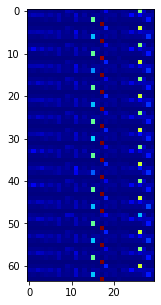

epochs: 1/100, train loss : 1.13554 train mse: 1.13554 train mae: 0.88480  validation loss: 0.91846 validation mse : 0.91846 validation mae: 0.78596
epochs: 2/100, train loss : 1.00271 train mse: 0.86988 train mae: 0.77042  validation loss: 0.82292 validation mse : 0.72738 validation mae: 0.69283
epochs: 3/100, train loss : 0.89537 train mse: 0.68067 train mae: 0.67361  validation loss: 0.75653 validation mse : 0.62375 validation mae: 0.63798
epochs: 4/100, train loss : 0.80531 train mse: 0.53514 train mae: 0.58959  validation loss: 0.70304 validation mse : 0.54257 validation mae: 0.59080
epochs: 5/100, train loss : 0.72805 train mse: 0.41903 train mae: 0.51488  validation loss: 0.65260 validation mse : 0.45084 validation mae: 0.53265
epochs: 6/100, train loss : 0.66190 train mse: 0.33113 train mae: 0.45202  validation loss: 0.61077 validation mse : 0.40161 validation mae: 0.49756
epochs: 7/100, train loss : 0.60558 train mse: 0.26766 train mae: 0.40158  validation loss: 0.57575 valida

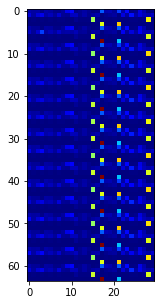

epochs: 11/100, train loss : 0.45190 train mse: 0.15222 train mae: 0.28973  validation loss: 0.46946 validation mse : 0.22002 validation mae: 0.35483
epochs: 12/100, train loss : 0.42601 train mse: 0.14121 train mae: 0.27662  validation loss: 0.44816 validation mse : 0.21381 validation mae: 0.34747
epochs: 13/100, train loss : 0.40352 train mse: 0.13363 train mae: 0.26670  validation loss: 0.42964 validation mse : 0.20751 validation mae: 0.34026
epochs: 14/100, train loss : 0.38387 train mse: 0.12851 train mae: 0.25976  validation loss: 0.41369 validation mse : 0.20623 validation mae: 0.33806
epochs: 15/100, train loss : 0.36661 train mse: 0.12500 train mae: 0.25459  validation loss: 0.39977 validation mse : 0.20493 validation mae: 0.33564
epochs: 16/100, train loss : 0.35136 train mse: 0.12258 train mae: 0.25093  validation loss: 0.38732 validation mse : 0.20060 validation mae: 0.33062
epochs: 17/100, train loss : 0.33780 train mse: 0.12088 train mae: 0.24818  validation loss: 0.37637

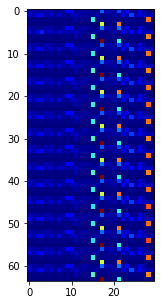

epochs: 21/100, train loss : 0.29603 train mse: 0.11754 train mae: 0.24291  validation loss: 0.34392 validation mse : 0.20955 validation mae: 0.33723
epochs: 22/100, train loss : 0.28789 train mse: 0.11705 train mae: 0.24207  validation loss: 0.33800 validation mse : 0.21362 validation mae: 0.34097
epochs: 23/100, train loss : 0.28045 train mse: 0.11668 train mae: 0.24169  validation loss: 0.33287 validation mse : 0.22016 validation mae: 0.34638
epochs: 24/100, train loss : 0.27361 train mse: 0.11623 train mae: 0.24107  validation loss: 0.32854 validation mse : 0.22885 validation mae: 0.35371
epochs: 25/100, train loss : 0.26730 train mse: 0.11580 train mae: 0.24054  validation loss: 0.32469 validation mse : 0.23222 validation mae: 0.35717
epochs: 26/100, train loss : 0.26146 train mse: 0.11548 train mae: 0.24015  validation loss: 0.32116 validation mse : 0.23305 validation mae: 0.35687
epochs: 27/100, train loss : 0.25604 train mse: 0.11529 train mae: 0.23968  validation loss: 0.31761

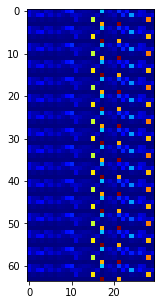

epochs: 31/100, train loss : 0.23773 train mse: 0.11354 train mae: 0.23772  validation loss: 0.30649 validation mse : 0.24535 validation mae: 0.36276
epochs: 32/100, train loss : 0.23384 train mse: 0.11329 train mae: 0.23737  validation loss: 0.30421 validation mse : 0.23344 validation mae: 0.35272
epochs: 33/100, train loss : 0.23018 train mse: 0.11282 train mae: 0.23689  validation loss: 0.30165 validation mse : 0.21975 validation mae: 0.34568
epochs: 34/100, train loss : 0.22671 train mse: 0.11242 train mae: 0.23661  validation loss: 0.29957 validation mse : 0.23071 validation mae: 0.35387
epochs: 35/100, train loss : 0.22344 train mse: 0.11200 train mae: 0.23588  validation loss: 0.29766 validation mse : 0.23300 validation mae: 0.35734
epochs: 36/100, train loss : 0.22032 train mse: 0.11128 train mae: 0.23483  validation loss: 0.29630 validation mse : 0.24859 validation mae: 0.36825
epochs: 37/100, train loss : 0.21736 train mse: 0.11064 train mae: 0.23403  validation loss: 0.29441

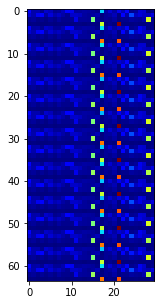

epochs: 41/100, train loss : 0.20686 train mse: 0.10893 train mae: 0.23224  validation loss: 0.28695 validation mse : 0.20772 validation mae: 0.33831
epochs: 42/100, train loss : 0.20453 train mse: 0.10900 train mae: 0.23207  validation loss: 0.28538 validation mse : 0.22089 validation mae: 0.34722
epochs: 43/100, train loss : 0.20231 train mse: 0.10916 train mae: 0.23231  validation loss: 0.28410 validation mse : 0.23021 validation mae: 0.35563
epochs: 44/100, train loss : 0.20016 train mse: 0.10773 train mae: 0.23055  validation loss: 0.28267 validation mse : 0.22123 validation mae: 0.34734
epochs: 45/100, train loss : 0.19809 train mse: 0.10664 train mae: 0.22914  validation loss: 0.28145 validation mse : 0.22772 validation mae: 0.35205
epochs: 46/100, train loss : 0.19609 train mse: 0.10635 train mae: 0.22851  validation loss: 0.27993 validation mse : 0.21168 validation mae: 0.33922
epochs: 47/100, train loss : 0.19417 train mse: 0.10564 train mae: 0.22770  validation loss: 0.27866

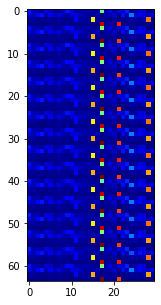

epochs: 51/100, train loss : 0.18709 train mse: 0.10278 train mae: 0.22404  validation loss: 0.27395 validation mse : 0.23156 validation mae: 0.35344
epochs: 52/100, train loss : 0.18547 train mse: 0.10248 train mae: 0.22377  validation loss: 0.27335 validation mse : 0.24290 validation mae: 0.36251
epochs: 53/100, train loss : 0.18389 train mse: 0.10191 train mae: 0.22304  validation loss: 0.27270 validation mse : 0.23897 validation mae: 0.36054
epochs: 54/100, train loss : 0.18237 train mse: 0.10166 train mae: 0.22274  validation loss: 0.27191 validation mse : 0.22971 validation mae: 0.35495
epochs: 55/100, train loss : 0.18089 train mse: 0.10136 train mae: 0.22217  validation loss: 0.27117 validation mse : 0.23154 validation mae: 0.35454
epochs: 56/100, train loss : 0.17946 train mse: 0.10073 train mae: 0.22162  validation loss: 0.27058 validation mse : 0.23812 validation mae: 0.35850
epochs: 57/100, train loss : 0.17809 train mse: 0.10103 train mae: 0.22212  validation loss: 0.26948

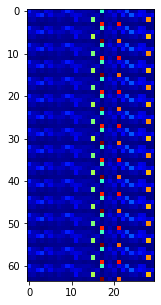

epochs: 61/100, train loss : 0.17294 train mse: 0.09917 train mae: 0.21932  validation loss: 0.26725 validation mse : 0.22505 validation mae: 0.34720
epochs: 62/100, train loss : 0.17174 train mse: 0.09813 train mae: 0.21816  validation loss: 0.26686 validation mse : 0.24290 validation mae: 0.36327
epochs: 63/100, train loss : 0.17055 train mse: 0.09709 train mae: 0.21651  validation loss: 0.26671 validation mse : 0.25726 validation mae: 0.37605
epochs: 64/100, train loss : 0.16939 train mse: 0.09642 train mae: 0.21590  validation loss: 0.26648 validation mse : 0.25183 validation mae: 0.37218
epochs: 65/100, train loss : 0.16826 train mse: 0.09582 train mae: 0.21501  validation loss: 0.26569 validation mse : 0.21507 validation mae: 0.33993
epochs: 66/100, train loss : 0.16717 train mse: 0.09620 train mae: 0.21566  validation loss: 0.26505 validation mse : 0.22399 validation mae: 0.34862
epochs: 67/100, train loss : 0.16610 train mse: 0.09571 train mae: 0.21447  validation loss: 0.26427

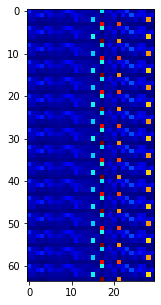

epochs: 71/100, train loss : 0.16207 train mse: 0.09314 train mae: 0.21098  validation loss: 0.26137 validation mse : 0.19410 validation mae: 0.32184
epochs: 72/100, train loss : 0.16110 train mse: 0.09231 train mae: 0.20990  validation loss: 0.26061 validation mse : 0.20667 validation mae: 0.33176
epochs: 73/100, train loss : 0.16015 train mse: 0.09154 train mae: 0.20888  validation loss: 0.26009 validation mse : 0.22231 validation mae: 0.34630
epochs: 74/100, train loss : 0.15921 train mse: 0.09095 train mae: 0.20808  validation loss: 0.25929 validation mse : 0.20068 validation mae: 0.32651
epochs: 75/100, train loss : 0.15832 train mse: 0.09212 train mae: 0.21039  validation loss: 0.25892 validation mse : 0.23155 validation mae: 0.35328
epochs: 76/100, train loss : 0.15745 train mse: 0.09212 train mae: 0.21045  validation loss: 0.25854 validation mse : 0.23036 validation mae: 0.35060
epochs: 77/100, train loss : 0.15660 train mse: 0.09244 train mae: 0.21078  validation loss: 0.25841

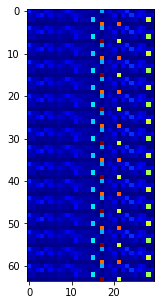

epochs: 81/100, train loss : 0.15327 train mse: 0.08865 train mae: 0.20486  validation loss: 0.25764 validation mse : 0.25058 validation mae: 0.37024
epochs: 82/100, train loss : 0.15249 train mse: 0.08959 train mae: 0.20665  validation loss: 0.25762 validation mse : 0.25612 validation mae: 0.37404
epochs: 83/100, train loss : 0.15172 train mse: 0.08844 train mae: 0.20495  validation loss: 0.25780 validation mse : 0.27212 validation mae: 0.39040
epochs: 84/100, train loss : 0.15098 train mse: 0.08937 train mae: 0.20620  validation loss: 0.25762 validation mse : 0.24329 validation mae: 0.36458
epochs: 85/100, train loss : 0.15025 train mse: 0.08892 train mae: 0.20586  validation loss: 0.25733 validation mse : 0.23244 validation mae: 0.35424
epochs: 86/100, train loss : 0.14953 train mse: 0.08868 train mae: 0.20509  validation loss: 0.25663 validation mse : 0.19744 validation mae: 0.32252
epochs: 87/100, train loss : 0.14885 train mse: 0.08996 train mae: 0.20746  validation loss: 0.25588

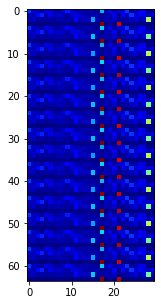

epochs: 91/100, train loss : 0.14615 train mse: 0.08624 train mae: 0.20183  validation loss: 0.25252 validation mse : 0.18733 validation mae: 0.31456
epochs: 92/100, train loss : 0.14549 train mse: 0.08550 train mae: 0.19976  validation loss: 0.25183 validation mse : 0.18881 validation mae: 0.31291
epochs: 93/100, train loss : 0.14484 train mse: 0.08469 train mae: 0.19924  validation loss: 0.25111 validation mse : 0.18547 validation mae: 0.31211
epochs: 94/100, train loss : 0.14419 train mse: 0.08448 train mae: 0.19859  validation loss: 0.25038 validation mse : 0.18255 validation mae: 0.30901
epochs: 95/100, train loss : 0.14357 train mse: 0.08441 train mae: 0.19883  validation loss: 0.24963 validation mse : 0.17914 validation mae: 0.30476
epochs: 96/100, train loss : 0.14295 train mse: 0.08472 train mae: 0.19928  validation loss: 0.24891 validation mse : 0.18025 validation mae: 0.30648
epochs: 97/100, train loss : 0.14234 train mse: 0.08374 train mae: 0.19784  validation loss: 0.24819

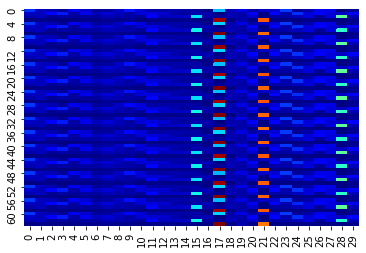

In [347]:
try :
    os.mkdir(f'../data/model_weights/model_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}')
except:
    print("폴더가 이미 존재")

visual_list = []
for epoch in range(EPOCHS):
    epoch_train_mse = 0
    epoch_train_mae = 0
    
    epoch_val_mse = 0
    epoch_val_mae = 0

    train_data_len = 0
    val_data_len = 0

    for train_X, train_y in train_dataset:
        _, train_mse, train_mae, attention_weights = train_function(train_X, train_y)
        train_data_len += 1
        epoch_train_mse += tf.reduce_mean(train_mse).numpy()
        epoch_train_mae += tf.reduce_mean(train_mae).numpy()
    for test_images, test_labels in val_dataset:
        _, val_mse, val_mae = test_function(test_images, test_labels)
        val_data_len += 1
        epoch_val_mse += tf.reduce_mean(val_mse).numpy()
        epoch_val_mae += tf.reduce_mean(val_mae).numpy()

    train_loss_list.append(train_loss.result().numpy())
    val_loss_list.append(val_loss.result().numpy())
    visual_result = VisualizeAttentionMap(model, train_X, attention_weights).on_epoch_begin(epoch)
    visual_list.append(visual_result.numpy())
    template = 'epochs: {}/{}, train loss : {:.5f} train mse: {:.5f} train mae: {:.5f}  validation loss: {:.5f} validation mse : {:.5f} validation mae: {:.5f}'
    print(template.format(epoch+1,
                         EPOCHS,
                         train_loss.result().numpy(),
                         epoch_train_mse / train_data_len,
                         epoch_train_mae / train_data_len,
                         val_loss.result().numpy(),
                         epoch_val_mse / val_data_len,
                         epoch_val_mae / val_data_len))
  
    if (epoch+1) % 10 == 0 :
        model.save_weights(f'../data/model_weights/model_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}/model_{epoch+1}.pth') 



try :
    os.mkdir(f'../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}')
except:
    print("폴더가 이미 존재")

for idx, img in enumerate(visual_list) :
    tmp = sns.heatmap(img, cmap ='jet', cbar = False)
    tmp.figure.savefig(f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}/{idx}.png")
    
    
    
path = [f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}/{i}" for i in os.listdir(f"../data/attention_weights/attention_png_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}") if i.endswith(".png")]
paths = [np.array(Image.open(i)) for i in path]

try :
    os.mkdir(f'../data/attention_weights/attention_result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}')
except :
    print("폴더가 이미 존재")
    
imageio.mimsave(f'../data/attention_weights/attention_result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}/result_{EPOCHS}_{look_back_window}_{forecast_horizon}_cluster_{cluster_num}.gif', paths, fps=5)

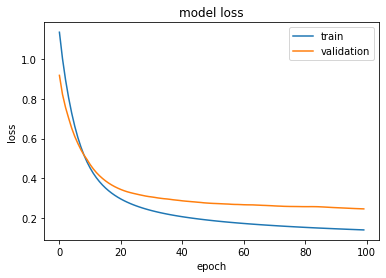

In [356]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

In [389]:
for i in range(10, 101 ,10) :
    model.load_weights(f"../data/model_weights/model_100_480_248_cluster_1/model_{i}.pth")
    X_test, y_test = preprocessor.transform(test_data.values)
    scores = np.mean(np.abs(y_test , model.predict(X_test)[0]))

    print(f"Model MAE : {scores}")

    # Predict
    y_pred,_ = model.predict(X_test)
    y_pred = preprocessor.y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test = preprocessor.y_scaler.inverse_transform(y_test.reshape(-1, 1))
    comparison = np.hstack([y_pred, y_test])
    print(np.mean(np.abs(y_test - y_pred)))

Model MAE : 0.7550469040870667
15091.45338095388
Model MAE : 0.7550469040870667
16054.024962394467
Model MAE : 0.7550469040870667
15212.068122125442
Model MAE : 0.7550469040870667
14292.908793787803
Model MAE : 0.7550469040870667
13209.500881195068
Model MAE : 0.7550469040870667
12295.11245825983
Model MAE : 0.7550469040870667
13279.159652217742
Model MAE : 0.7550469040870667
12467.634970388104
Model MAE : 0.7550469040870667
11950.567044165826
Model MAE : 0.7550469040870667
12029.010922339654


In [397]:
X_test, y_test = preprocessor.transform(test_data.values)
model.load_weights(f"../data/model_weights/model_100_480_248_cluster_1/model_90.pth")
y_pred,_ = model.predict(X_test)
y_pred = preprocessor.y_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = preprocessor.y_scaler.inverse_transform(y_test.reshape(-1, 1))
comparison = np.hstack([y_pred, y_test])
print(np.mean(np.abs(y_test - y_pred)))

11950.567044165826


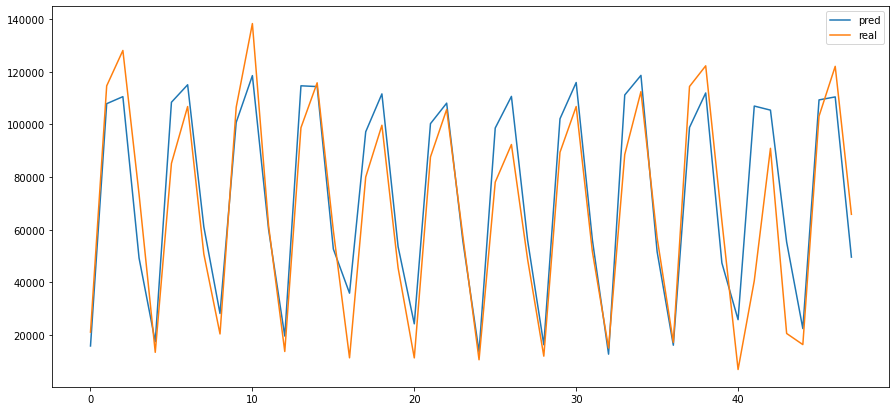

In [398]:
plt.figure(figsize=(15,7))
plt.plot(comparison[200:400])
plt.legend(['pred','real'])
plt.show()

In [399]:
data = pd.read_csv(f'../data/processed_data/클러스터_{cluster_num}_최종피쳐.csv', encoding = 'cp949')
final_test_data = data[-look_back_window:]

In [400]:
final_dong_list = final_test_data.읍면동.unique()
final_test_data.drop(columns = '읍면동', inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [405]:
final_test_data = final_test_data.set_index(['일자'])

In [406]:
a = scaler.transform(final_test_data)

In [407]:
np.asarray([a]).shape

(1, 480, 30)

In [408]:
y_pred,_ = model.predict(np.asarray([a]))

In [409]:
y_pred = preprocessor.y_scaler.inverse_transform(y_pred.reshape(-1, 1))

In [410]:
y_pred

array([[ 18458.02  ],
       [104534.46  ],
       [125223.31  ],
       [ 55655.742 ],
       [ 18250.875 ],
       [101757.97  ],
       [127182.47  ],
       [ 52225.062 ],
       [ 18902.203 ],
       [110183.8   ],
       [136789.78  ],
       [ 52729.504 ],
       [ 14387.651 ],
       [119962.87  ],
       [125424.06  ],
       [ 58874.273 ],
       [ 22324.477 ],
       [112602.58  ],
       [129940.695 ],
       [ 57337.035 ],
       [ 23738.355 ],
       [102487.19  ],
       [125767.66  ],
       [ 53680.848 ],
       [ 22905.25  ],
       [104290.43  ],
       [125859.31  ],
       [ 57028.43  ],
       [ 17789.121 ],
       [104731.01  ],
       [134941.2   ],
       [ 43156.953 ],
       [ 16948.852 ],
       [ 98920.664 ],
       [125172.19  ],
       [ 63722.332 ],
       [ 18494.688 ],
       [102024.37  ],
       [124327.67  ],
       [ 59939.582 ],
       [ 18579.629 ],
       [112861.52  ],
       [127018.11  ],
       [ 52055.105 ],
       [ 10445.03  ],
       [10

In [411]:
final_test_data = data[-look_back_window:]

In [412]:
list(final_dong_list)

['봉개동', '삼양동', '아라동', '오라동']

In [413]:
final_dong_cluster_1 = list(final_dong_list) * int(y_pred.shape[0] / len(final_dong_list))

In [414]:
final_result = pd.DataFrame(np.vstack([final_dong_cluster_1,np.reshape(y_pred, (y_pred.shape[0]))]).T, columns=['읍면동','7_8월예측값'])

In [417]:
final_result[final_result['7_8월예측값'].astype('float') < 0 ] #음수값이 있나 확인

,읍면동,7_8월예측값


In [416]:
final_result.to_csv(f'../data/processed_data/cluster_{cluster_num}_final_result.csv', encoding = 'cp949', index = False)